In [52]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.distributions.uniform import Uniform
from torch.utils.data import TensorDataset, DataLoader

import lightning as L

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
inputs = torch.tensor([[1., 0., 0., 0.],
                      [0., 1., 0., 0.],
                      [0., 0., 1., 0.],
                      [0., 0., 0., 1.]])

labels = torch.tensor([[0., 1., 0., 0.],
                      [0., 0., 1., 0.],
                      [0., 0., 0., 1.],
                      [0., 1., 0., 0.]])

In [54]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

This is a visualization of the map

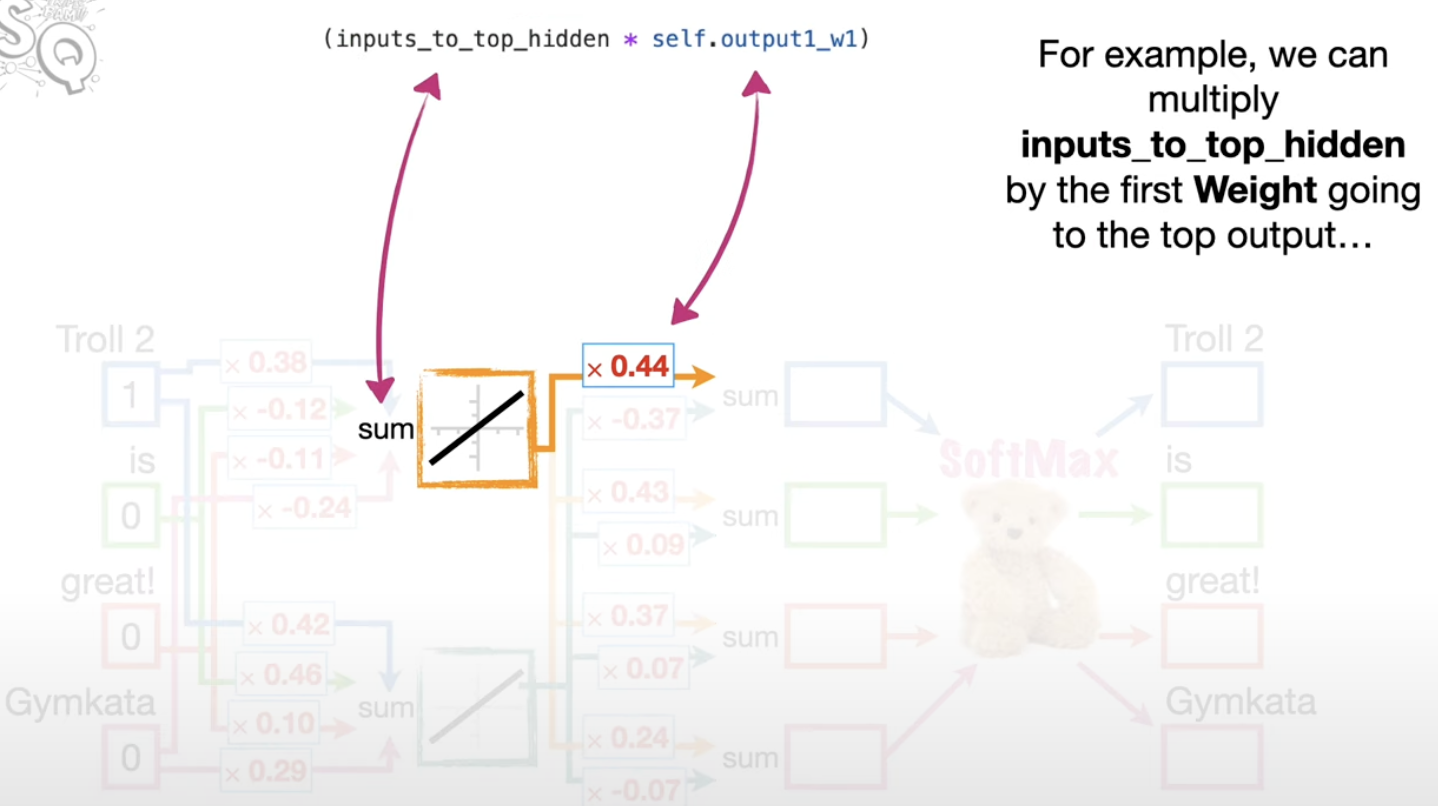

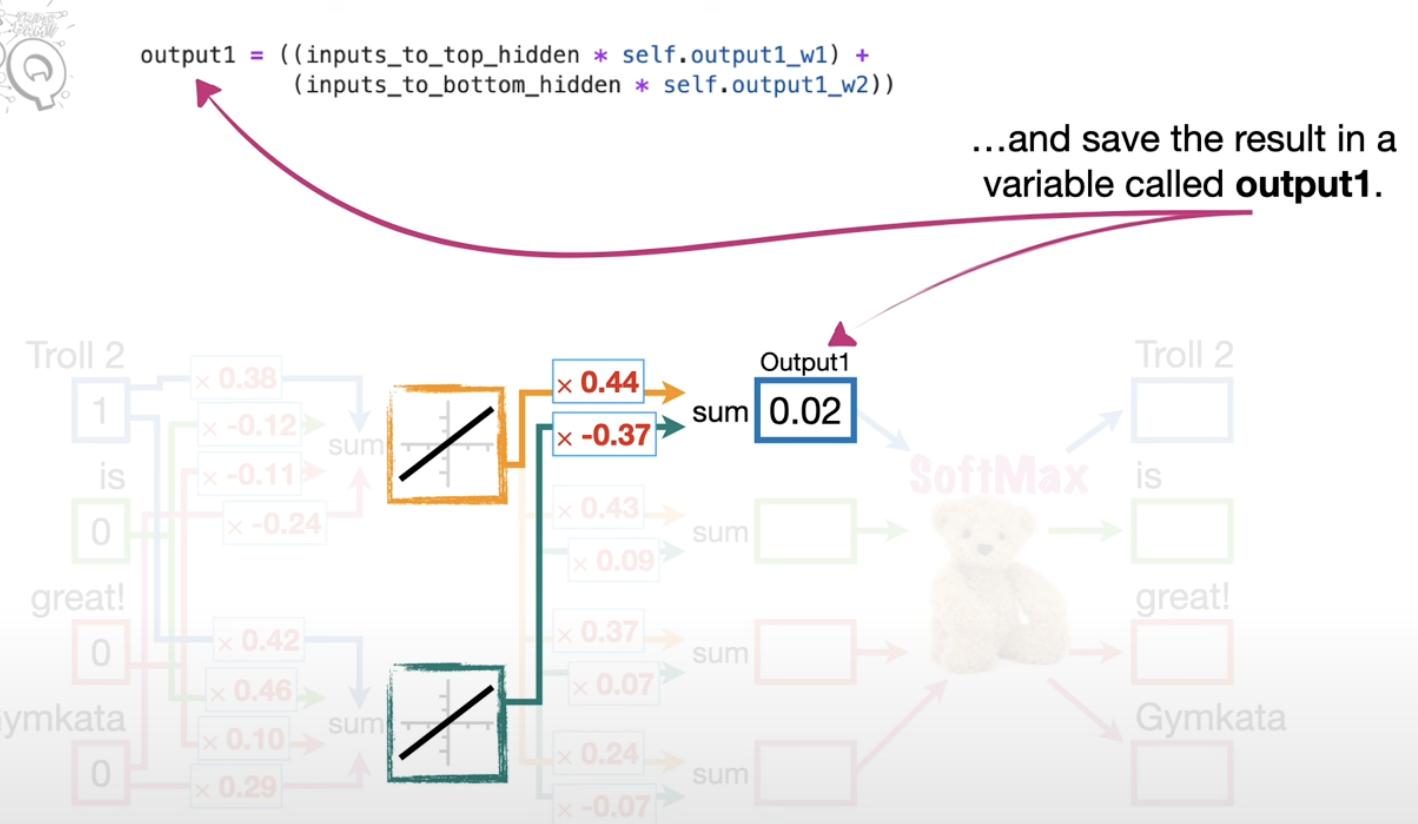

In [55]:
class WordEmbeddingFromScratch(L.LightningModule):
    #create and initialize weight tensors + create loss function
    #initialize all weight tensors that we need to implement the embedding network
    def __init__(self):
        super().__init__()

        # Define min and max values for uniform distribution
        min_value = -0.5
        max_value = 0.5

        # Sample tensors from a uniform distribution and create parameters
        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        # Loss function
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):

    
        input = input[0] #when passed to forward mehtod its wrapped in extra set of brackets

        inputs_to_top_hidden = ((inputs[0] * self.input1_w1) +
                             (inputs[1] * self.input2_w1) +
                             (inputs[2] * self.input3_w1) +
                             (inputs[3] * self.input4_w1))
        
        inputs_to_bottom_hidden = ((inputs[0] * self.input1_w2) +
                             (inputs[1] * self.input2_w2) +
                             (inputs[2] * self.input3_w2) +
                             (inputs[3] * self.input4_w2))
        
        output1 = ((inputs_to_bottom_hidden * self.output1_w1)+ 
                  (inputs_to_bottom_hidden * self.output1_w2))


        output2 = ((inputs_to_bottom_hidden * self.output2_w1)+ 
                  (inputs_to_bottom_hidden * self.output2_w2))\
                  
        output3 = ((inputs_to_bottom_hidden * self.output3_w1)+ 
                  (inputs_to_bottom_hidden * self.output3_w2))
        
        output4 = ((inputs_to_bottom_hidden * self.output4_w1)+ 
                  (inputs_to_bottom_hidden * self.output4_w2))

        #the loss function we are using for backpropogatin does the softmax for us
        #using torch.stack preserves the gradient
        output_presoftmax = torch.stack([output1, output2, output3, output4])
        return output_presoftmax

    def configure_optimizers(self):
        return Adam(self.parameters())

    #calculates loss
    def training_step(self, batch, batch_idx):
         # Move batch to the correct device
        input_i, label_i = batch
        input_i = input_i.to(self.device)
        label_i = label_i.to(self.device)

        # Forward pass
        output_i = self.forward(input_i)

        # Calculate the loss
        loss = self.loss(output_i, label_i)
        return loss



In [56]:
modelFromScratch = WordEmbeddingFromScratch()
print("Before Optimization")

for name, param in modelFromScratch.named_parameters():
    print(name, param.data)


Before Optimization
input1_w1 tensor(-0.0136)
input1_w2 tensor(0.2101)
input2_w1 tensor(-0.0904)
input2_w2 tensor(0.4427)
input3_w1 tensor(-0.3974)
input3_w2 tensor(0.0441)
input4_w1 tensor(0.3683)
input4_w2 tensor(-0.2330)
output1_w1 tensor(0.2750)
output1_w2 tensor(0.2440)
output2_w1 tensor(0.3846)
output2_w2 tensor(-0.3408)
output3_w1 tensor(0.4344)
output3_w2 tensor(0.0575)
output4_w1 tensor(-0.4036)
output4_w2 tensor(0.0342)


In [57]:
data = {
    "w1": [modelFromScratch.input1_w1.item(),
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input23", "input4"]
}

df = pd.DataFrame(data)

In [58]:
df

,w1,w2,token,input
0,-0.013606,0.210076,Troll2,input1
1,-0.090409,0.442676,is,input2
2,-0.397382,0.044148,great,input23
3,0.368330,-0.232957,Gymkata,input4


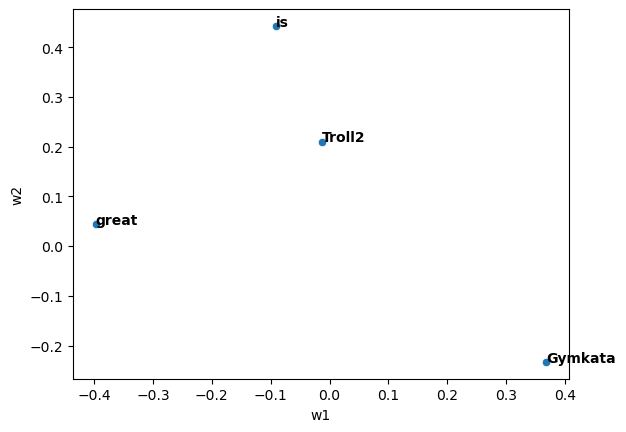

In [59]:
sns.scatterplot(data = df, x = "w1", y = "w2")
#to get labels on each data point
plt.text(df.w1[0], df.w2[0], df.token[0],
         horizontalalignment = 'left',
         size = 'medium',
         color = 'black',
         weight = 'semibold')

plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment = 'left',
         size = 'medium',
         color = 'black',
         weight = 'semibold')

plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment = 'left',
         size = 'medium',
         color = 'black',
         weight = 'semibold')

plt.text(df.w1[3], df.w2[3], df.token[3],
         horizontalalignment = 'left',
         size = 'medium',
         color = 'black',
         weight = 'semibold')

plt.show()

In [60]:
import torch

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
modelFromScratch.to(device)


WordEmbeddingFromScratch(
  (loss): CrossEntropyLoss()
)

In [61]:
trainer = L.Trainer(max_epochs=100)

# Train the model
trainer.fit(modelFromScratch, train_dataloaders=dataloader)




GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | CrossEntropyLoss | 0      | train
  | other params | n/a              | 16     | n/a  
----------------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training b

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!